# CS 4700 - Homework \#3, Part 1
**Due Date: Friday, 12/7 @ 6pm on CMS**

---
## Section 1: Introduction

In this assignment, you will be implementing an (artificial) **neural network**, training and testing it in Python 3. The assignment requires an additional library to handle plotting the graphs. If you do not have `matplotlib` installed on your machine, please run the following commands to do so:

`python3 -m pip install -U pip` <br/>
`python3 -m pip install -U matplotlib`

For more information about this package (and possible troubleshooting if the above installation does not work), please visit their [website](https://matplotlib.org/). Once you have it successfully installed, let's start by importing it (and others) into the notebook. Note, these are the only `import` statements allowed for this assignment; anything else will result in a penalty!

In [1]:
import math
import random
import matplotlib.pyplot as plt

We begin the assignment by first defining what exactly is a neural network (NN). Recall from lecture that a NN is a collection of **units** or **nodes**, each of which uses an activation function to propagate its input signals as an output signal. These units are connected via weighted links. Every unit also has a bias term that can be represented as a dummy input with a fixed output value of 1. For simplicity, we will assume our NNs are **feed-forward NNs**, which can be represented as a directed acyclic graph of units.

The code cell below defines the `NNUnit` class, which will represent a unit in a NN. Creating an actual NN is handled by the function `createNN`. Start the assignment by reading through and understanding the code below.

In [2]:
"""
A unit of a neural network.
"""
class NNUnit:
    def __init__(self, activation, inputs = None, weights = None):
        self.activation = activation
        self.inputs = inputs or []
        self.weights = weights or []
        self.value = None


"""
Creates a neural network.
"""
def createNN(input_layer_size, hidden_layer_sizes, output_layer_size, activation):
    layer_sizes = [input_layer_size] + hidden_layer_sizes + [output_layer_size]
    network = [[NNUnit(activation) for _ in range(s)] for s in layer_sizes]
    dummy_node = NNUnit(activation)
    dummy_node.value = 1.0
    
    # create weighted links
    for layer_idx in range(1, len(layer_sizes)):
        for node in network[layer_idx]:
            node.inputs.append(dummy_node)
            node.weights.append(0.0)
            for input_node in network[layer_idx - 1]:
                node.inputs.append(input_node)
                node.weights.append(0.0)
    
    return network

The last thing we will need for our NN representation is an activation function. For now, let's use the sigmoid function, $\sigma(z)$. The derivative of the sigmoid will become necessary for the next section. For reference, here are the equations:

$$
\begin{aligned}
\sigma(z) &= \frac{1}{1 + e^{-z}} \\
\frac{d}{dz}\sigma(z) &= \sigma(z) \times (1 - \sigma(z))
\end{aligned}
$$

### <span style="color:blue"> Q1.  Properties of Activation Functions </span>

1. What would happen if we use the identity function, i.e., $\sigma(z) := z$, as an activation function? Hint: what kind of functions can the network approximate? What is the effect of adding more layers?
0. Consider the end behavior of the sigmoid function and its derivative --- as $z$ gets far away from zero, what happens? 
0. Interpret this in the context of a neural network: what does this mean for activations, and for the training process?

### <span style="color:red"> P1.  Implement Sigmoid and Its Derivative </span>

Note, for these two functions, you do **not** need to add documentation. The implementation should be very straight-forward.

In [3]:
def sigmoid(z):
    return(1/(1+math.exp(-z)))


def sigmoid_deriv(z):
    return(sigmoid(z)*(1-sigmoid(z)))

---
## Section 2: Back-Propagation Algorithm

As you learned in lecture, we can teach our NN to learn by adjusting the weights of each link. These adjustments are derived by propagating backwards the error from the output layer. We will be running this back-propagation algorithm on the following NN:

![](neural_net.png)

Note that green represents input nodes, goldenrod represents hidden nodes, blue represents output nodes, and pink is the dummy node. Our goal is for this NN to learn the 2-bit adder function. The truth table for this operation is:

| $x_1$ | $x_2$ | $y_1$<br/>(carry) | $y_2$<br/>(sum) |
| :---: | :---: | :---: | :---: |
| 0 | 0 | 0 | 0 |
| 0 | 1 | 0 | 1 |
| 1 | 0 | 0 | 1 |
| 1 | 1 | 1 | 0 |

For reference, here is the back-propagation algorithm in pseudo-code, taken from the textbook (fig. 18.24).
![](back-prop_pseudo.png)

### <span style="color:blue"> Q2a.  Symbols </span>
What do $a_i$, $\Delta[i]$, and $w_{i,j}$ represent?



$a_i$ represents the value at each node which is got after summing over the product of weights in inputs and applying an activation function over it.

$\Delta_i$ represents the gradient descent that needs to be taken so that the deviation of the ouput from the neural network from the expected output is minimized.

$w_{i,j}$ represents the weight mapping from node $i$ to node $j$. In other words, a node $i$ receives a weight w from a node $j$

### <span style="color:blue"> Q2b.  Manual Back-Propagation </span>
Before we implement the back-propagation algorithm, let's actually work out the math for entry 3 of the above data set (inputs are 1 and 0, outputs are 0 and 1). This will be useful for you in ensuring you understand the algorithm. You will perform one iteration of the algorithm, i.e., forward propagate the inputs, backward propagate the errors, and adjust the weights. Assume the initial weights for links coming out of units 1, 3, and 5 are 0.6, the initial weights for links coming out of units 2, 4, and 6 are 0.2, and the initial weights for links coming out of dummy unit 0 is 0.5.

Fill out the math cell below with your results. You must show your work for each calculation; simply writing the value will not receive credit. The recommended way for you to do this is as follows: first, write down the general formula, evaluated as far as you can knowing everything except the index. Then, write the  unevaluated formula, and the result.

Note, if you are unfamiliar with $\LaTeX$, you can write your solutions out in plain, boring text. But we **strongly** urge you to take some time to learn the basics of $\LaTeX$ to make some beautiful math!

$$ a_i := \sigma(w_{0,i} + \Sigma (w_{i,j}*a_j)) $$

$$
\begin{gather}
a_1 = 1? \qquad\\
a_2 = 0? \qquad\\
a_3 =\sigma(w_{0,3} + 0.6(a_1) + 0.2(a_2)) = \sigma(0.5 + 0.6(1) + 0.2(0)) = \sigma(0.5 + 0.6) = \sigma(1.1) = 0.75 \qquad\\
a_4 =\sigma(w_{0,4} + 0.6(a_1) + 0.2(a_2)) = \sigma(0.5 + 0.6(1) + 0.2(0)) = \sigma(0.5 + 0.6) = \sigma(1.1) = 0.75 \\
a_5 =\sigma(w_{0,5} + 0.6(a_3) + 0.2(a_4)) = \sigma(0.5 + 0.6(0.75) + 0.2(0.75)) = \sigma(0.5 + 0.45 + 0.15) = \sigma(1.1) = 0.75\qquad\\
a_6 =\sigma(w_{0,6} + 0.6(a_3) + 0.2(a_4)) = \sigma(0.5 + 0.6(0.75) + 0.2(0.75)) = \sigma(0.5 + 0.45 + 0.15) = \sigma(1.1) = 0.75\qquad\\
a_7 =\sigma(w_{0,7} + 0.6(a_5) + 0.2(a_6)) = \sigma(0.5 + 0.6(0.75) + 0.2(0.75)) = \sigma(0.5 + 0.45 + 0.15) = \sigma(1.1) = 0.75\qquad\\
a_8 = \sigma(w_{0,8} + 0.6(a_3) + 0.2(a_4)) = \sigma(0.5 + 0.6(0.75) + 0.2(0.75)) = \sigma(0.5 + 0.45 + 0.15) = \sigma(1.1) = 0.75\qquad\\
\end{gather}
$$

$$ z = (w_{0,i} + \Sigma (w_{i,j}*a_j)) $$
$$ \Delta_i := (\sigma(z))*(1 - (\sigma(z))*(\Sigma (w_{i,j}*\Delta_j)) $$
$$
\begin{gather}
\Delta_8 = \frac{1}{1+e^{-z}}*(1-\frac{1}{1+e^{-z}})*\Delta_j = \frac{1}{1+e^{-1.1}}*(1-\frac{1}{1+e^{-1.1}})(1 - 0.75) = (0.75)*(0.25)*(0.25) = 0.047\qquad\\
\Delta_7 = \frac{1}{1+e^{-z}}*(1-\frac{1}{1+e^{-z}})*\Delta_j = \frac{1}{1+e^{-1.1}}*(1-\frac{1}{1+e^{-1.1}})(0 - 0.75) = (0.75)*(0.25)*(-0.75) = -0.141\qquad\\
\Delta_6 = \frac{1}{1+e^{-z}}*(1-\frac{1}{1+e^{-z}})*\Delta_j = \frac{1}{1+e^{-1.1}}*(1-\frac{1}{1+e^{-1.1}})([0.2*0.047] + [0.2*-0.141]) = -0.00352 \qquad\\
\Delta_5 = \frac{1}{1+e^{-z}}*(1-\frac{1}{1+e^{-z}})*\Delta_j = \frac{1}{1+e^{-1.1}}*(1-\frac{1}{1+e^{-1.1}})([0.6*0.047] + [0.6*-0.141]) = -0.01056\\
\Delta_4 = \frac{1}{1+e^{-z}}*(1-\frac{1}{1+e^{-z}})*\Delta_j = \frac{1}{1+e^{-1.1}}*(1-\frac{1}{1+e^{-1.1}})([0.2*-0.00352] + [0.2*-0.01056]) = -5.7276x10^{-4} \qquad\\
\Delta_3 = \frac{1}{1+e^{-z}}*(1-\frac{1}{1+e^{-z}})*\Delta_j = \frac{1}{1+e^{-1.1}}*(1-\frac{1}{1+e^{-1.1}})([0.6*-0.00352] + [0.6*-0.01056]) = -0.00158 \qquad\\
\Delta_2 = \frac{1}{1+e^{-z}}*(1-\frac{1}{1+e^{-z}})*\Delta_j = \frac{1}{1+e^{-1.1}}*(1-\frac{1}{1+e^{-1.1}})([0.2*-5.7276x10^{-4}] - [0.2*-0.00158]) = -7.896x10^{-5}\qquad\\
\Delta_1 = \frac{1}{1+e^{-z}}*(1-\frac{1}{1+e^{-z}})*\Delta_j = \frac{1}{1+e^{-1.1}}*(1-\frac{1}{1+e^{-1.1}})([0.6*-5.7276x10^{-4}] - [0.6*-0.00158]) = -2.369x10^{-4}  \\
\end{gather}
$$


$$ w_{i,j} := w_{i,j} + \alpha * a_i * \Delta_j $$
$$
\begin{gather}
w_{0,3} = 0.5 + (0.1 * 1 * -0.00158) = 0.4999842 \qquad\\
w_{1,3} = 0.6 + (0.1 * 1 * -0.00158) = 0.5999842 \qquad\\
w_{2,3} = 0.2 + (0.1 * 1 * 0) = 0.2 \qquad\\
w_{0,4} = 0.5 + (0.1 * 1 * -5.7276x10^{-4}) = 0.49999473 \qquad\\
w_{1,4} = 0.6 + (0.1 * 1 * -5.7276x10^{-4}) = 0.59999473 \qquad\\
w_{2,4} = 0.2 + (0.1 * 1 * 0) = 0.2 \qquad\\
w_{0,5} = 0.5 + (0.1 * 1 * -0.01056) = 0.495944\qquad\\
w_{3,5} = 0.6 + (0.1 * 0.75 * -0.01056) = 0.5992 \qquad\\
w_{4,5} = 0.2 + (0.1 * 0.75 * -0.01056) = 0.1992 \qquad\\
w_{0,6} = 0.5 + (0.1 * 1 * -0.00352) = 0.499648 \qquad\\
w_{3,6} = 0.6 + (0.1 * 0.75 * -0.00352) = 0.599736\qquad\\
w_{4,6} = 0.2 + (0.1 * 0.75 * -0.00352) = 0.199736 \qquad\\
w_{0,7} = 0.5 + (0.1 * 1 * -0.141) = 0.4859 \qquad\\
w_{5,7} = 0.6 + (0.1 * 0.75 * -0.141) = 0.589425 \qquad\\
w_{6,7} = 0.2 + (0.1 * 0.75 * -0.141) = 0.189425 \qquad\\
w_{0,8} = 0.5 + (0.1 * 1 * 0.047) = 0.5047 \\
w_{5,8} = 0.6 + (0.1 * 0.75 * 0.047) = 0.603 \\
w_{6,8} = 0.2 + (0.1 * 0.75 * 0.047) = 0.2035\\
\end{gather}
$$

### <span style="color:red"> P2.  Back-Propagation Implementation </span>
There are some modifications we will be making to the above pseudo-code as well as some assumptions:
+ initialize the weights with random values only once, rather than every iteration of the **repeat-until**
+ in that same vain, $\Delta$ should only be initialized once with starting value 0 for each node
+ random numbers should come from a uniform distribution \[-0.5, 0.5\] (use `random.uniform` for this)
+ the **repeat-until** condition will be the number of epochs, given as parameter `epochs`
+ assume `network` is fully-connected between layers
+ $\alpha$ refers to the learning rate, given as parameter `learning_rate`
+ in addition to returning `network`, the function should also output a list of total mean squared error (MSE) per epoch
  + $MSE_e = \frac{1}{k} \sum_j (y_j - a_j)^2$
  + $Total\ MSE = \sum_e MSE_e$
  + $e$ is indexing over examples, $k$ is the number of output units, and $j$ is indexing over the output units

In [4]:
"""
Your documentation here.
"""
def back_prop_learning(examples, network, epochs, learning_rate, deriv = sigmoid_deriv):
    
    
    k = len(network[-1])
    totalMSE = []
    inmatrix = []
    deltamatrix = []
    #inmatrix = [[0 for ex in network[0]] for ex3 in network] # change
    #deltamatrix = [[0 for ex in network[0]] for ex3 in network] #change 
    for eachlayer in range(len(network)):
        inmatappend = []
        delmatappend = []
        for eachnode in range(len(network[eachlayer])):
            inmatappend.append(0)
            delmatappend.append(0)
        inmatrix.append(inmatappend)
        deltamatrix.append(delmatappend)

    for eachlayer in network:
        for eachnode in eachlayer:
            for eachweight in range(len(eachnode.weights)):
                eachnode.weights[eachweight] = random.uniform(-0.5,0.5)
                
    while epochs != 0:
    #Initialize weights for all nodes in all layers 
        for x,y in examples:
            sumMSE = []
            index = 0
        #assign values to input nodes
            for eachnode in network[0]:
                eachnode.value = x[index]
                index += 1
            
            #assign values to all other nodes
            layerindex = 1
            for eachlayer in network[1:]:
                nodeindex = 0
                for eachnode in eachlayer:
                    index = 0
                    summweights = 0
                    for eachinput in eachnode.inputs:
                        summweights += eachinput.value*eachnode.weights[index]
                        index += 1
                    eachnode.value = sigmoid(summweights)
                    inmatrix[layerindex][nodeindex] = summweights
                    nodeindex += 1
                layerindex += 1
        #delta calculation at output layer
            nodeindex = 0
            for eachnode in network[-1]:
                s = inmatrix[-1][nodeindex]
                deltamatrix[-1][nodeindex] = (deriv(s)*(y[nodeindex] - eachnode.value))
                nodeindex += 1
        #error backpropogation

            count = 0
            layerindex = (len(network) - 2)
            for eachlayer in network[-2::-1]:
                nodeindex = 0
                for eachnode in eachlayer:
                    weightsdelta = 0
                    deltaindex = 0
                    sigmaderiv = deriv(inmatrix[layerindex][nodeindex])
                    for eachnextnode in (network[layerindex+1]):
                        count += 1
                        eachweight = eachnextnode.weights[nodeindex+1]
                        weightsdelta += (eachweight*deltamatrix[layerindex+1][deltaindex])
                        deltaindex += 1
                    deltamatrix[layerindex][nodeindex]= sigmaderiv*weightsdelta
                    nodeindex += 1
                layerindex -= 1
           
            
            layerindex = 1
            for eachlayer in network[1:]:
                nodeindex = 0
                for eachnode in eachlayer:
                    weightindex = 0
                    for eachweight in network[layerindex][nodeindex].weights:
                        value = network[layerindex][nodeindex].inputs[weightindex].value
                        network[layerindex][nodeindex].weights[weightindex] += learning_rate*value*deltamatrix[layerindex][nodeindex]
                        weightindex += 1
                    nodeindex += 1
                layerindex += 1
            
            #MSE Calculation
            index = 0
            errorrate = 0
            for eachnode in network[-1]:
                sumindex = 0
                errorrate += (y[index] - eachnode.value)**2
                index += 1
            sumMSE.append(errorrate/k)
        totalMSE.append(sum(sumMSE))
        epochs -= 1
    return network,totalMSE

In [260]:
lis = [1,2,3,4,5]
print(lis[-2::-1])

[4, 3, 2, 1]


---
## Section 3: Training and Testing

Now that our NNs can learn, it's time to train and test! The code cell below will load in the 4 possible cases of the 2-bit adder as training data. After learning, we will graph how the total MSE changes over time. If you implemented the back-propagation algorithm correctly, you should see a downward trend, on average, as the total error approaches 0. You might need to run this cell a few times, as the starting weights can affect the total MSE.

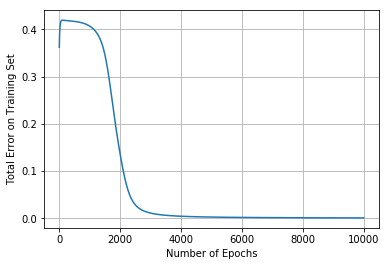

In [261]:
dataset = [([0,0],[0,0]), ([0,1],[0,1]), ([1,0],[0,1]), ([1,1],[1,0])]
network = createNN(2, [2,2], 2, sigmoid)
num_epochs = 10000
trained_network, total_errs = back_prop_learning(dataset, network, num_epochs, 0.25)
_, axis = plt.subplots()
epochs = [e for e in range(0, num_epochs, 1)]
axis.plot(epochs, total_errs)
axis.set(xlabel = 'Number of Epochs', ylabel = 'Total Error on Training Set')
axis.grid()
plt.show()

### <span style="color:blue"> Q3. Leaking Information </span>
1. Why should we not test on the same data set that we used for training?
0. Recall or look up the term **cross-validation** and explain how this process allows for both more training and testing data.
0. Suppose that our model does not do well on the testing set, so we look at the testing set to figure out why. Once we understand why it's made mistakes, we go back and make some changes to the architecture --- maybe we delete some edges or add some nodes. When we run our experiment, it performs better! Are these results still valid?

### <span style="color:red"> P3. Prediction </span>
After the training phase comes the testing phase. To see how well our learned network performs on test data, we first need to make a prediction. In our NNs, this is done by propagating the input signals forward, and then returning the values of the output layer. Capture this logic in the function `predict`.

In [262]:
"""
Your documentation here.
"""
def predict(network, example):
    preds = []
    x = example
    index = 0
    #assign values to input nodes
    for eachnode in network[0]:
        eachnode.value = x[index]
        index += 1         
    #assign values to all other nodes
    layerindex = 1
    for eachlayer in network[1:]:
        nodeindex = 0
        for eachnode in eachlayer:
            index = 0
            summweights = 0
            for eachinput in eachnode.inputs:
                summweights += eachinput.value*eachnode.weights[index]
                index += 1
            eachnode.value = sigmoid(summweights)
            nodeindex += 1
        layerindex += 1
        
    for eachnode in network[-1]:
        preds.append(eachnode.value)
    
    return preds

Now that we can make predictions, let's first see if our NN really did learn the 2-bit adder function. The code cell below makes a prediction for each of the 4 cases and compares that to the correct outputs. On average, the learned network should get deviations very close to 0.

In [263]:
test_set = [[0,0], [0,1], [1,0], [1,1]]
correct_out = [[0,0], [0,1], [0,1], [1,0]]
for t in range(len(test_set)):
    print('Example =', test_set[t])
    preds = predict(trained_network, test_set[t])
    print('Prediction =', preds)
    print('Actual =', correct_out[t])
    devs = [abs(preds[p] - correct_out[t][p]) for p in range(len(preds))]
    print('Deviations =', devs)
    print()

Example = [0, 0]
Prediction = [0.009475399715381071, 0.6871597003758873]
Actual = [0, 0]
Deviations = [0.009475399715381071, 0.6871597003758873]

Example = [0, 1]
Prediction = [0.009800768821621491, 0.6840203112721248]
Actual = [0, 1]
Deviations = [0.009800768821621491, 0.3159796887278752]

Example = [1, 0]
Prediction = [0.009814962030044299, 0.6838841406848115]
Actual = [0, 1]
Deviations = [0.009814962030044299, 0.3161158593151885]

Example = [1, 1]
Prediction = [0.9779584160584235, 0.033680589799382016]
Actual = [1, 0]
Deviations = [0.022041583941576515, 0.033680589799382016]



Of course, the above only proved that our trained NN simply "memorized" the training set, since we are using the same data for testing. Let's see how well our back-propagation learning performs for data it has not seen. The code cell below generates 16 examples. 12 of those will randomly be used as training, and the other 4 will be used for testing. Try running this cell a few times to see how the error plot and error rate changes. You might also want to play around with the NN architecture, the number of epochs, or the learning rate.

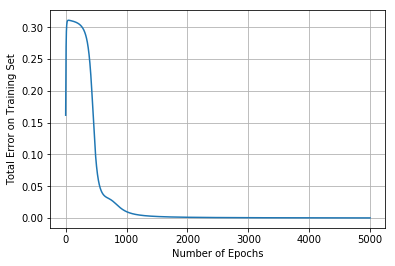

Error Rate: 12.5 %


In [264]:
data_set = [([p,q,r,s],[int(p and not r), int(q <= p)]) for p in [0,1] for q in [0,1] for r in [0,1] for s in [0,1]]
random.shuffle(data_set)
training_set = data_set[0:12]
network = createNN(4, [8,8], 2, sigmoid)
num_epochs = 5000
trained_network, total_errs = back_prop_learning(training_set, network, num_epochs, 0.1)
_, axis = plt.subplots()
epochs = [e for e in range(0, num_epochs, 1)]
axis.plot(epochs, total_errs)
axis.set(xlabel = 'Number of Epochs', ylabel = 'Total Error on Training Set')
axis.grid()
plt.show()
test_set = [x for (x,y) in data_set[12:]]
correct_out = [y for (x,y) in data_set[12:]]
num_misses = 0
for t in range(len(test_set)):
    preds = predict(trained_network, test_set[t])
    devs = [abs(preds[p] - correct_out[t][p]) for p in range(len(preds))]
    for d in devs:
        if d >= 0.1:
            num_misses += 1
print('Error Rate:', num_misses / 8.0 * 100.0, '%')

---
## Section 4: Exploring Different Hyperparameters

Thus far, we have used a fixed set of hyperparameters for our NN; let's explore a bit in this section. First, let's take a look at how our choice of activation function can affect the learning phase. Below, implement the following functions as well as their derivatives. (Note, $\alpha$ is a constant real number where applicable.)

$$
\begin{align}
\sin(z) &= \sin(z) &
\frac{\mathrm d}{\mathrm dz} \sin(z) &= \cos(z) \\[0.5em]
\tanh(z) &= \frac{e^z - e^{-z}}{e^z + e^{-z}} &
\frac{\mathrm d}{\mathrm dz} \tanh(z) &= 1 - \tanh(z)^2 \\[0.5em]
\mathrm{elu}(z) &= 
  \begin{cases}
    z & \text{$z > 0$} \\
    \alpha (e^z - 1) & \text{$z \leq 0$}
  \end{cases} &
\frac{\mathrm d}{\mathrm dz} \mathrm{elu}(z) &= 
  \begin{cases}
    1 & \text{$z > 0$} \\
    \alpha (e^z) & \text{$z < 0$}
  \end{cases} \\[0.5em]
\mathrm{relu}(z) &= 
  \begin{cases}
    z & \text{$z > 0$} \\
    0 & \text{$z \leq 0$}
  \end{cases} &
\frac{\mathrm d}{\mathrm dz} \mathrm{relu}(z) &= 
  \begin{cases}
    1 & \text{$z > 0$} \\
    0 & \text{$z < 0$}
  \end{cases}
\end{align}
$$

For the trigonometric functions, it is okay to simply call the respective function from `math`. Also, for these functions, you do **not** need to document. These are relatively straight-forward, but take care with the ELU and ReLU derivatives!

### <span style="color:red"> P4. Alternate Activation Functions </span>

In [11]:
def sin(z):
    return (math.sin(z))


def sin_deriv(z):
    return (math.cos(z))


def tanh(z):
    numerator = math.exp(z) - math.exp(-z)
    denominator = math.exp(z) + math.exp(-z)
    return(numerator/denominator)


def tanh_deriv(z):
    return((1-tanh(z)**2))


def elu(z, alpha = 0.01):
    if z > 0:
        return z
    else:
        return(alpha*(math.exp(z)-1))


def elu_deriv(z, alpha = 0.01):
    if z > 0:
        return 1
    else:
        return(alpha*(math.exp(z)))

def relu(z):
    if z > 0:
        return z
    else:
        return 0


def relu_deriv(z):
    if z > 0:
        return 1
    else:
        return 0

With these different activation functions implemented, let's see how it affects the NN for our 2-bit adder data set. Try re-running this cell a few times.

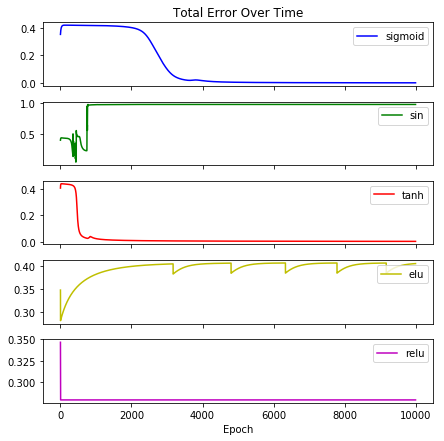

In [12]:
training_set = [([0,0],[0,0]), ([0,1],[0,1]), ([1,0],[0,1]), ([1,1],[1,0])]
learning_rate = 0.25
num_epochs = 10000
funs = [sigmoid, sin, tanh, elu, relu]
drvs = [sigmoid_deriv, sin_deriv, tanh_deriv, elu_deriv, relu_deriv]
errs = []
r = random.getstate()
for f in range(len(funs)):
    network = createNN(2, [2,2], 2, funs[f])
    random.setstate(r)
    _, total_errs = back_prop_learning(training_set, network, num_epochs, learning_rate, deriv = drvs[f])
    errs.append(total_errs)
fig, axs = plt.subplots(5, 1, sharex = True, figsize = (7, 7))
fig.subplots_adjust(hspace = 0.25)
t = [i for i in range(0, num_epochs, 1)]
axs[0].plot(t, errs[0], color = 'b', label = 'sigmoid')
axs[1].plot(t, errs[1], color = 'g', label = 'sin')
axs[2].plot(t, errs[2], color = 'r', label = 'tanh')
axs[3].plot(t, errs[3], color = 'y', label = 'elu')
axs[4].plot(t, errs[4], color = 'm', label = 'relu')
axs[0].set(title = 'Total Error Over Time')
axs[4].set(xlabel = 'Epoch')
for i in range(len(axs)):
    axs[i].legend(loc = 'upper right')
plt.show()

One other hyperparameter we will explore is the learning rate. For our 2-bit adder data set, we have used a fixed learning rate of 0.25. How does the learning rate affect back-propagation learning? Write code for `check_alphas` that will try learning rates between `min_alpha` and `max_alpha`, with a step-size of `step_size`. For each new $\alpha$, keep track of the total MSE of the final epoch, as this is what `check_alphas` should output.

### <span style="color:red"> P5. Learning Rates </span>

In [18]:
"""
Your documentation here.
"""
def check_alphas(examples, network, epochs, min_alpha, max_alpha, step_size, deriv = sigmoid_deriv):
    MSEarray = []
    while min_alpha <= max_alpha:
        learning_rate = min_alpha
        _, total_errs = back_prop_learning(examples, network, epochs, learning_rate, deriv = sigmoid_deriv)
        MSEarray.append(total_errs[-1])
        min_alpha +=  step_size
    return MSEarray

Finally, let's see how these different learning rates compare. Try different activation functions as well, to see how the choice of learning rate can affect the total error. (Be careful with ELU and ReLU!)

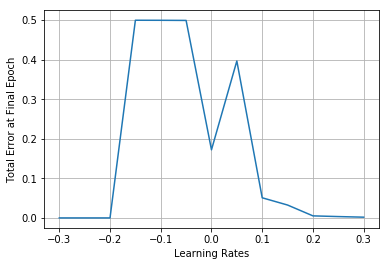

In [19]:
dataset = [([0,0],[0,0]), ([0,1],[0,1]), ([1,0],[0,1]), ([1,1],[1,0])]
network = createNN(2, [2,2], 2, sigmoid)
num_epochs = 5000
mina = -0.3
maxa = 0.3
ss = 0.05
errs = check_alphas(dataset, network, num_epochs, mina, maxa, ss, sigmoid_deriv)
_, axis = plt.subplots()
alphas = []
while mina <= maxa:
    alphas.append(mina)
    mina += ss
axis.plot(alphas, errs)
axis.set(xlabel = 'Learning Rates', ylabel = 'Total Error at Final Epoch')
axis.grid()
plt.show()

### <span style="color:blue"> Q4. Hyperparameters </span>
1. What conclusions can we draw about different activation functions and learning rates?
0. Explain the term **P-hacking** and why it might be relevant here. There is a single, very commonly used term that is used in ML to refer to this: what is it?
0. Use your answers to the previous questions to explain why in practice we partition labeled data into three subsets: a training set, a testing set, and a validation set.

---
## Section 5: Submission

You will only be submitting your Jupyter notebook file, *hwk3_part1.ipynb*. Do not worry about submitting the additional files. Furthermore, as a reminder, part of your grade is your documentation. Each of the functions you implemented as part of this assignment **must** be documented. Documentation can include (but is not limited to): summary, purpose, inputs, outputs, assumptions, runtime, Python ~~hacks~~ tricks. Failure to include proper documentation will result in a penalty.

Please upload your *hwk3.ipynb* file to CMS by **Friday, 12/7 @ 6pm**.